In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.dates as mdates

In [88]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [89]:
data = pd.read_csv(r'C:\Users\p\Downloads\train_train.csv')

In [90]:
import datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['dayofweek'] = data['timestamp'].dt.dayofweek

data

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0,2022,1,27,3
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0,2022,1,28,4
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0,2022,1,29,5
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0,2022,1,30,6


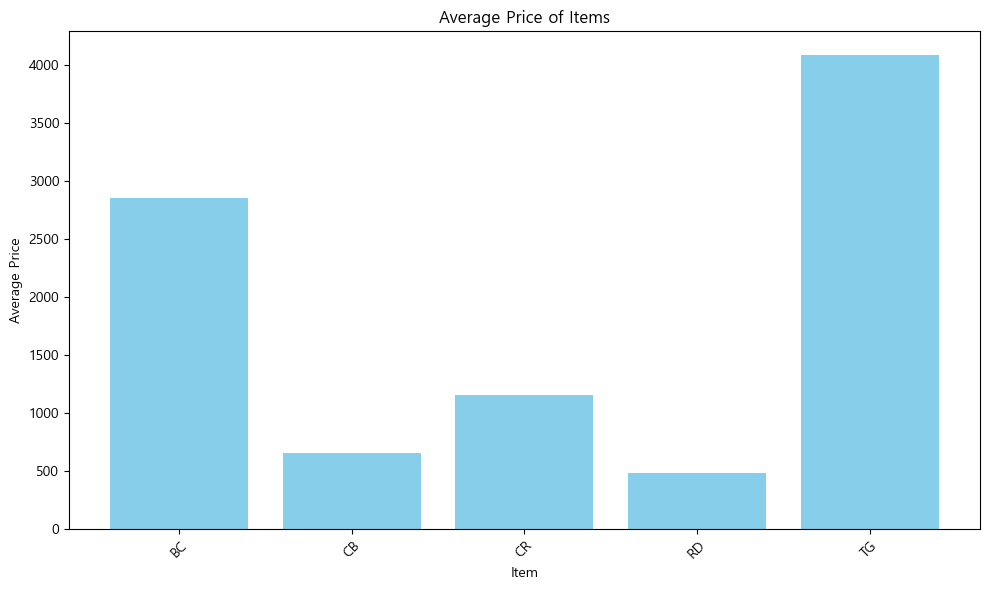

In [91]:
# price 값이 0이 아닌 행만 필터링합니다.
filtered_data = data[data['price(원/kg)'] != 0]

# 'item' 칼럼을 기준으로 그룹화하고 평균을 구합니다.
grouped_data = filtered_data.groupby('item')['price(원/kg)'].mean().reset_index()

# 그래프를 그립니다.
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['item'], grouped_data['price(원/kg)'], color='skyblue')
plt.xlabel('Item')
plt.ylabel('Average Price')
plt.title('Average Price of Items')
plt.xticks(rotation=45)  # x 축 레이블 회전
plt.tight_layout()
plt.show()


In [92]:
encoding_columns = ['item','corporation', 'location']
not_encoding_columns = ['ID', 'timestamp', 'supply(kg)', 'price(원/kg)', 'year', 'month', 'day', 'dayofweek']

In [93]:
# 범주형 데이터 변환

enc_classes = {}

def encoding_labels(x):
    le = LabelEncoder()
    label = le.fit_transform(x)
    enc_classes[x.name] = le.classes_
    return label

In [94]:
d1 = data[encoding_columns].apply(encoding_labels)
d1.head()

,item,corporation,location
0,4,0,0
1,4,0,0
2,4,0,0
3,4,0,0
4,4,0,0


In [95]:
d2 = data[not_encoding_columns]
d2.head()

,ID,timestamp,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20190101,2019-01-01,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,32352.0,1250.0,2019,1,5,5


In [96]:
data = d1.join(d2)
data

,item,corporation,location,ID,timestamp,supply(kg),price(원/kg),year,month,day,dayofweek
0,4,0,0,TG_A_J_20190101,2019-01-01,0.0,0.0,2019,1,1,1
1,4,0,0,TG_A_J_20190102,2019-01-02,0.0,0.0,2019,1,2,2
2,4,0,0,TG_A_J_20190103,2019-01-03,60601.0,1728.0,2019,1,3,3
3,4,0,0,TG_A_J_20190104,2019-01-04,25000.0,1408.0,2019,1,4,4
4,4,0,0,TG_A_J_20190105,2019-01-05,32352.0,1250.0,2019,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
43948,3,5,0,RD_F_J_20220127,2022-01-27,522900.0,536.0,2022,1,27,3
43949,3,5,0,RD_F_J_20220128,2022-01-28,435800.0,588.0,2022,1,28,4
43950,3,5,0,RD_F_J_20220129,2022-01-29,422700.0,623.0,2022,1,29,5
43951,3,5,0,RD_F_J_20220130,2022-01-30,484440.0,481.0,2022,1,30,6


Root Mean Squared Error: 906.4016002428576
R-squared: 0.8020409026768316
       Actual    Predicted
23357     0.0    14.314418
32715  2134.0  1945.298706
36420  2375.0  2474.709717
22879     0.0   108.823326
7600      0.0   136.728043
...       ...          ...
17026     0.0   294.241852
1215   4800.0  5019.623535
5825   5726.0  5654.145020
346    1216.0   256.967560
31356     0.0    16.954243

[13186 rows x 2 columns]


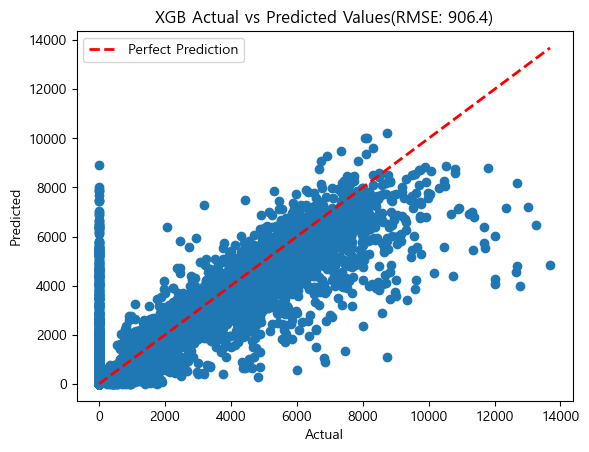

In [97]:
# Feature와 Target 데이터셋 분리
X = data[['item','corporation','location','year','month','day','dayofweek']]
y = data['price(원/kg)']

# 학습 데이터셋과 테스트 데이터셋으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 정의 및 훈련
model = XGBRegressor()
model.fit(X_train, y_train)

# Pred 사용하여 예측값 계산
y_pred = model.predict(X_test)
y_pred = np.where(y_pred<0, 0, y_pred)

# RMSE 사용
rmse = mean_squared_error(y_test, y_pred, squared = False)
print("Root Mean Squared Error:", rmse)

# R Squred
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

# 예측값과 실제값 비교 및 정렬
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison)


# 시각화
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.title(f'XGB Actual vs Predicted Values(RMSE: {round(rmse, 2)})')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

In [98]:
test_data = pd.read_csv(r'C:\Users\p\Downloads\train_test.csv')
test_data

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0
...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0


In [99]:
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

test_data['year'] = test_data['timestamp'].dt.year
test_data['month'] = test_data['timestamp'].dt.month
test_data['day'] = test_data['timestamp'].dt.day
test_data['dayofweek'] = test_data['timestamp'].dt.dayofweek

test_data

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0,2022,2,1,1
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0,2022,2,2,2
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0,2022,2,3,3
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0,2022,2,4,4
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0,2022,2,5,5
...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0,2022,2,24,3
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0,2022,2,25,4
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0,2022,2,26,5
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0,2022,2,27,6


In [100]:
encoding_columns = ['item','corporation', 'location']
not_encoding_columns = ['ID', 'timestamp','year', 'month', 'day', 'dayofweek','supply(kg)','price(원/kg)']

In [101]:
enc_classes = {}

def encoding_labels(x):
    le = LabelEncoder()
    label = le.fit_transform(x)
    enc_classes[x.name] = le.classes_
    return label

In [102]:
d1 = test_data[encoding_columns].apply(encoding_labels)
d1.head()

,item,corporation,location
0,4,0,0
1,4,0,0
2,4,0,0
3,4,0,0
4,4,0,0


In [103]:
d2 = test_data[not_encoding_columns]
d2.head()

,ID,timestamp,year,month,day,dayofweek,supply(kg),price(원/kg)
0,TG_A_J_20220201,2022-02-01,2022,2,1,1,0.0,0.0
1,TG_A_J_20220202,2022-02-02,2022,2,2,2,0.0,0.0
2,TG_A_J_20220203,2022-02-03,2022,2,3,3,0.0,0.0
3,TG_A_J_20220204,2022-02-04,2022,2,4,4,535.5,6065.0
4,TG_A_J_20220205,2022-02-05,2022,2,5,5,5893.0,3113.0


In [104]:
test_data = d1.join(d2)
test_data

,item,corporation,location,ID,timestamp,year,month,day,dayofweek,supply(kg),price(원/kg)
0,4,0,0,TG_A_J_20220201,2022-02-01,2022,2,1,1,0.0,0.0
1,4,0,0,TG_A_J_20220202,2022-02-02,2022,2,2,2,0.0,0.0
2,4,0,0,TG_A_J_20220203,2022-02-03,2022,2,3,3,0.0,0.0
3,4,0,0,TG_A_J_20220204,2022-02-04,2022,2,4,4,535.5,6065.0
4,4,0,0,TG_A_J_20220205,2022-02-05,2022,2,5,5,5893.0,3113.0
...,...,...,...,...,...,...,...,...,...,...,...
1087,3,5,0,RD_F_J_20220224,2022-02-24,2022,2,24,3,478500.0,532.0
1088,3,5,0,RD_F_J_20220225,2022-02-25,2022,2,25,4,568800.0,520.0
1089,3,5,0,RD_F_J_20220226,2022-02-26,2022,2,26,5,478320.0,509.0
1090,3,5,0,RD_F_J_20220227,2022-02-27,2022,2,27,6,0.0,0.0


In [105]:
X_new = test_data[['item','corporation','location','year','month','day','dayofweek']]
y_pred_new = model.predict(X_new)
y_pred_new = np.where(y_pred_new<0, 0, y_pred_new)
test_data['predicted_price'] = y_pred_new
print(test_data)

      item  corporation  location               ID  timestamp  year  month  \
0        4            0         0  TG_A_J_20220201 2022-02-01  2022      2   
1        4            0         0  TG_A_J_20220202 2022-02-02  2022      2   
2        4            0         0  TG_A_J_20220203 2022-02-03  2022      2   
3        4            0         0  TG_A_J_20220204 2022-02-04  2022      2   
4        4            0         0  TG_A_J_20220205 2022-02-05  2022      2   
...    ...          ...       ...              ...        ...   ...    ...   
1087     3            5         0  RD_F_J_20220224 2022-02-24  2022      2   
1088     3            5         0  RD_F_J_20220225 2022-02-25  2022      2   
1089     3            5         0  RD_F_J_20220226 2022-02-26  2022      2   
1090     3            5         0  RD_F_J_20220227 2022-02-27  2022      2   
1091     3            5         0  RD_F_J_20220228 2022-02-28  2022      2   

      day  dayofweek  supply(kg)  price(원/kg)  predicted_price 

In [106]:
# FacetGrid 생성
g = sns.FacetGrid(test_data, col='item', col_wrap=3, height=4, aspect=1.5)

# 각 아이템별로 그래프 그리기
g.map_dataframe(sns.lineplot, x='timestamp', y='price(원/kg)', label='Actual Price')
g.map_dataframe(sns.lineplot, x='timestamp', y='predicted_price', linestyle='--', label='Predicted Price')
g.set_axis_labels('Timestamp', 'Price(원/kg)')
g.set_titles('Actual vs Predicted Prices over Time for {col_name}')
g.add_legend()
plt.xticks(rotation=45)  # 눈금 레이블 45도 회전
plt.tight_layout()
plt.show()

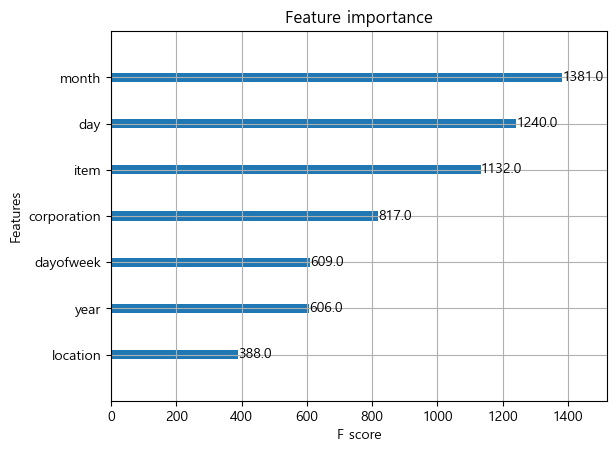

In [ ]:
# 특성 중요도 시각화
plot_importance(model)
plt.show()